### Regression model result

In [213]:
import numpy as np
import random
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import os
from sklearn.feature_selection import RFECV
import pandas as pd
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error
import numpy as np
from numpy.lib.function_base import average
import pandas as pd
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error,explained_variance_score,max_error
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import importlib
import os
from sklearn.feature_selection import (
    SelectKBest,
    RFE,
    mutual_info_regression,
    f_regression,
    mutual_info_classif,
)
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import xgboost as xgb
import random
import pickle
import openpyxl
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import pickle
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import random
import importlib
import seaborn as sns
import pandas as pd
import numpy as np

In [195]:
wor_dir="/home/fbf/"
wor_dir="C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\IBF-Typhoon-model\\"

os.chdir(wor_dir)

cdir = os.getcwd()

In [196]:
file_name = "models/output/v1/df_predicted_xgb_regr_.csv"
path = os.path.join(cdir, file_name)
df_predicted_xgb_regr=pd.read_csv(path)

file_name = "models/output/v1/df_predicted_rf_regr1.csv"
path = os.path.join(cdir, file_name)
df_predicted_rf_regr=pd.read_csv(path)

file_name = "models/output/v1/df_predicted_mean.csv"
path = os.path.join(cdir, file_name)
df_predicted_mean=pd.read_csv(path)
file_name = "models/output/v1/df_predicted_lr.csv"
path = os.path.join(cdir, file_name)
df_predicted_lr=pd.read_csv(path)



file_name = "models/output/v1/df_predicted_damagecurve.csv"

path = os.path.join(cdir, file_name)



df_predicted_damagecurve=pd.read_csv(path)
df_predicted_damagecurve=df_predicted_damagecurve[df_predicted_damagecurve['typhoon'].isin(list(df_predicted_lr.typhoon.values))]

file_name='data/metadata_typhoons_typ.csv'
path = os.path.join(cdir, file_name)
df_typhoon_typ=pd.read_csv(path)
def catagory(x):
    if x in ['TS','TD']:
        CAT='TY Cat 1'
    else:
        CAT =x   
    return CAT

df_typhoon_typ['cat']=df_typhoon_typ.apply(lambda x:catagory(x['cat']),axis=1).values

 

In [216]:
models = {
    "Random Forest": df_predicted_rf_regr,
    "XGBoost": df_predicted_xgb_regr,
    "Average": df_predicted_mean,
    "Simple Linear Regression": df_predicted_lr,
    "UPCL damage curve": df_predicted_damagecurve,
}

mae = []
rmse = []
mape= []
mape2= []
EVS=[]

#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))
    return mape

def MAB_A(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)))
    return mape 

def MAB(Y_actual,Y_Predicted):
    mape =np.mean((Y_Predicted-Y_actual))
    return mape

from statistics import variance
# add 'list' if error
for df_temp in models.values():
    df_temp["actual"].replace({0: 0.001,}, inplace=True)
    df_temp["predicted"].replace({0: 0.001,}, inplace=True)
    mae.append(mean_absolute_error(df_temp["actual"], df_temp["predicted"]))
    rmse.append(mean_squared_error(df_temp["actual"], df_temp["predicted"], squared=False))
    mape.append(mean_absolute_percentage_error(df_temp["actual"], df_temp["predicted"]))
    mape2.append(MAB(df_temp["actual"], df_temp["predicted"]))
    EVS.append(explained_variance_score(df_temp["actual"], df_temp["predicted"]))
    
df_results_regr = pd.DataFrame({"Models": list(models.keys()), "MAE": mae, "RMSE": rmse,"MAPE": mape,"MAPE2": mape2,"EVS": EVS})
df_results_regr

,Models,MAE,RMSE,MAPE,MAPE2,EVS
0,Random Forest,2.478111,7.731188,128.972339,-0.066948,0.297788
1,XGBoost,2.365182,7.957106,156.296375,-0.594909,0.260251
2,Average,3.963652,9.288241,1283.307657,-0.008358,-0.013619
3,Simple Linear Regression,3.886010,8.386995,804.824109,-0.083065,0.173623
4,UPCL damage curve,2.536873,9.475106,15.182206,-1.428668,-0.030834


### Model performance validation per typhoon event (only part of the data is used for model training)
1) Average Performance of different models 

In [220]:
### Results 

models = {
    "Random Forest": df_predicted_rf_regr,
    "XGBoost": df_predicted_xgb_regr,
    "Average": df_predicted_mean,
    "Simple Linear Regression": df_predicted_lr,
    "UPCL damage curve": df_predicted_damagecurve,
}

maedic = {}
rmsedic = {}
mapedict={}
mapedict2={}
evsdict={}

# add 'list' if error
for keys,df_temp in models.items():
    mae = []
    rmse = []
    mape= []
    mape2= []
    evs=[]
    typhoon=[]
    for key,groups in df_temp.groupby(['typhoon']):
        df_temp["actual"].replace({0: 0.001,}, inplace=True)
        df_temp["predicted"].replace({0: 0.001,}, inplace=True)
        mae.append(mean_absolute_error(groups["actual"], groups["predicted"]))
        rmse.append(mean_squared_error(groups["actual"], groups["predicted"], squared=False))
        mape.append(mean_absolute_percentage_error(groups["actual"], groups["predicted"]))
        mape2.append(MAB(df_temp["actual"], df_temp["predicted"]))        
        evs.append(explained_variance_score(groups["actual"], groups["predicted"]))
        typhoon.append(key)
        
    maedic[keys]=mae
    rmsedic[keys]=rmse
    mapedict[keys]=mape
    mapedict2[keys]=mape2
    evsdict[keys]=evs

#df_results_regr = pd.DataFrame({"Models": list(models.keys()), "MAE": mae, "RMSE": rmse})


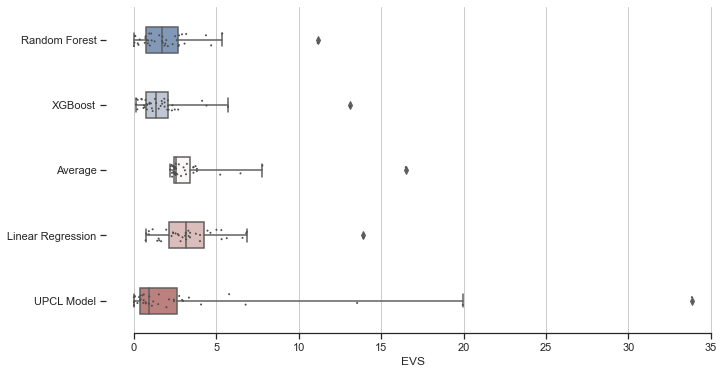

In [221]:
df_results_regr = pd.DataFrame(maedic)
df_results_regr.rename(columns={"Simple Linear Regression": "Linear Regression","UPCL damage curve": "UPCL Model"},inplace=True)


# Melt the DataFrame
games_melted = pd.melt(df_results_regr, 
                       value_vars=['Random Forest','XGBoost','Average','Linear Regression','UPCL Model'], 
                       var_name='Models', 
                       value_name='EVS')

plt.rcParams.update({'font.size': 18})
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(11, 6))
#ax.set_xscale("log")

 
# Plot the orbital period with horizontal boxes
sns.boxplot(y='Models', x='EVS', data=games_melted,
            whis=[0, 99], width=.4, palette="vlag")

# Add in points to show each observation
sns.stripplot(y='Models', x='EVS', data=games_melted,
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
sns.despine(trim=True, left=True)
#f.savefig('algorithms_comparsion_evs.jpg', format='jpg', dpi=600)

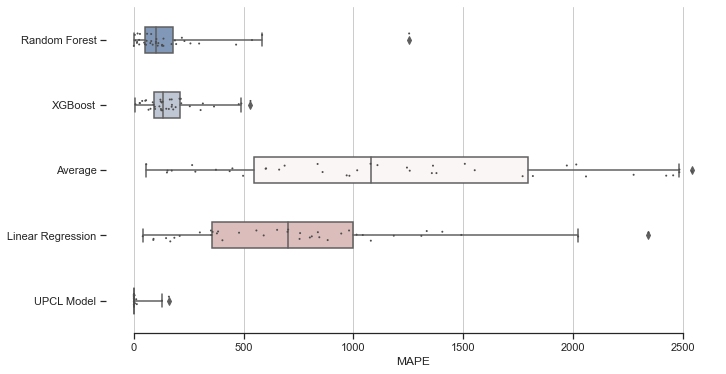

In [224]:
df_results_regr = pd.DataFrame(mapedict)
df_results_regr.rename(columns={"Simple Linear Regression": "Linear Regression","UPCL damage curve": "UPCL Model"},inplace=True)


# Melt the DataFrame
games_melted = pd.melt(df_results_regr, 
                       value_vars=['Random Forest','XGBoost','Average','Linear Regression','UPCL Model'], 
                       var_name='Models', 
                       value_name='MAPE')

plt.rcParams.update({'font.size': 18})
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(11, 6))
#ax.set_xscale("log")

 
# Plot the orbital period with horizontal boxes
sns.boxplot(y='Models', x='MAPE', data=games_melted,
            whis=[0, 99], width=.4, palette="vlag")

# Add in points to show each observation
sns.stripplot(y='Models', x='MAPE', data=games_melted,
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
sns.despine(trim=True, left=True)
##f.savefig('algorithms_comparsion_mape.jpg', format='jpg', dpi=600)

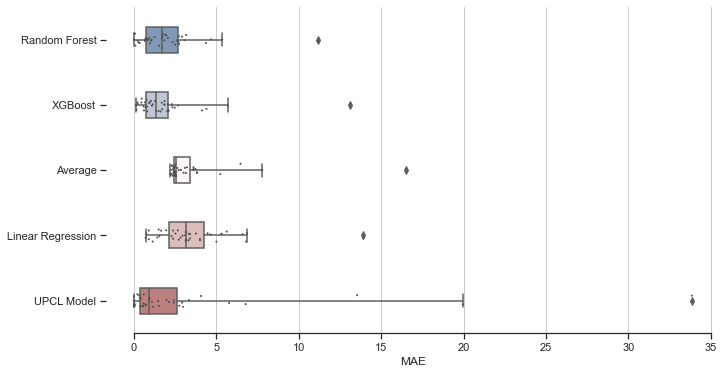

In [225]:
df_results_regr = pd.DataFrame(maedic)
df_results_regr.rename(columns={"Simple Linear Regression": "Linear Regression","UPCL damage curve": "UPCL Model"},inplace=True)


# Melt the DataFrame
games_melted = pd.melt(df_results_regr, 
                       value_vars=['Random Forest','XGBoost','Average','Linear Regression','UPCL Model'], 
                       var_name='Models', 
                       value_name='MAE')

plt.rcParams.update({'font.size': 18})
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(11, 6))
#ax.set_xscale("log")

 
# Plot the orbital period with horizontal boxes
sns.boxplot(y='Models', x='MAE', data=games_melted,
            whis=[0, 99], width=.4, palette="vlag")

# Add in points to show each observation
sns.stripplot(y='Models', x='MAE', data=games_melted,
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
sns.despine(trim=True, left=True)
f.savefig('algorithms_comparsion_mae.jpg', format='jpg', dpi=600)

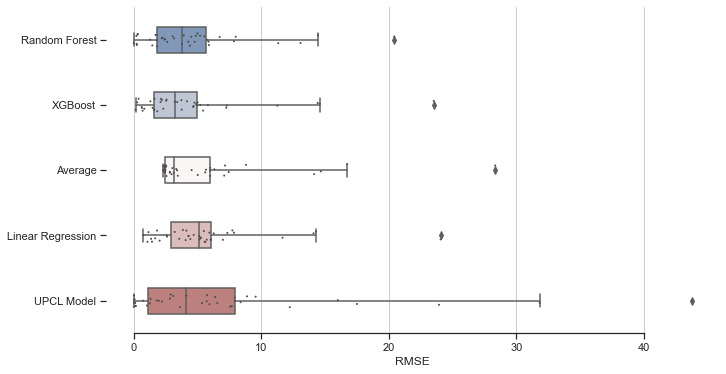

In [226]:
df_results_regr = pd.DataFrame(rmsedic)
df_results_regr.rename(columns={"Simple Linear Regression": "Linear Regression","UPCL damage curve": "UPCL Model"},inplace=True)


# Melt the DataFrame
games_melted = pd.melt(df_results_regr, 
                       value_vars=['Random Forest','XGBoost','Average','Linear Regression','UPCL Model'], 
                       var_name='Models', 
                       value_name='RMSE')

plt.rcParams.update({'font.size': 18})
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(11, 6))
#ax.set_xscale("log")

 
# Plot the orbital period with horizontal boxes
sns.boxplot(y='Models', x='RMSE', data=games_melted,
            whis=[0, 99], width=.4, palette="vlag")

# Add in points to show each observation
sns.stripplot(y='Models', x='RMSE', data=games_melted,
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
sns.despine(trim=True, left=True)
f.savefig('algorithms_comparsion_RMSE.jpg', format='jpg', dpi=600)

In [176]:
### compare performance per typhoon event

In [227]:
mae1 = []
rmse1= []

# add 'list' if error
for df_temp in models.values():
    mae = {}
    rmse = {}
    for name, group in  df_temp.groupby('typhoon'):     
        mae[name]=mean_absolute_error(group["actual"], group["predicted"])
        rmse[name]=mean_squared_error(group["actual"], group["predicted"], squared=False)
    mae1.append(mae)
    rmse1.append(rmse1)
    
df = pd.DataFrame(mae1)
df.index=models.keys()
dff=df.unstack() 
dff.index = dff.index.set_names(['typhoon', 'Model'])
reset_df = dff.reset_index()
reset_df=reset_df.rename(columns={0:'MAE'})

In [228]:
#reset_df.set_index('typhoon',inplace=True)

reset_df=reset_df.join(df_typhoon_typ.set_index('typhoon'), on='typhoon')

In [232]:
#reset_df.to_csv("MAE.csv")


2) perfromance per typhoon event 

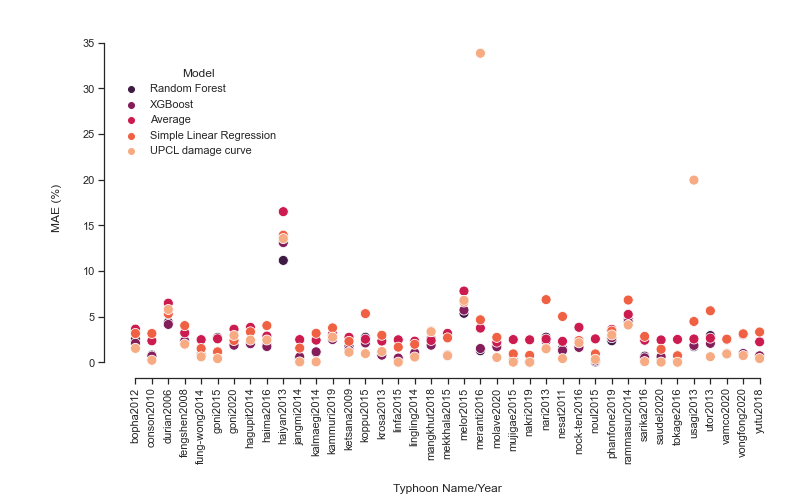

In [230]:
plt.rcParams.update({'font.size': 20}) 
g=sns.relplot(
    data=reset_df,#.query("type=='TY'"),
    x="typhoon", y="MAE", hue="Model",# style="Model", 
    palette="rocket", marker="o", s=100,
)
g.set_axis_labels("Typhoon Name/Year", "MAE (%)", labelpad=20)
#g.legend.set_title("Model")
g.figure.set_size_inches(18.5, 6)
g.set_xticklabels(rotation=90)
g.ax.margins(.05)
g.despine(trim=True) 
#g.add_legend(frameon=True)
g.legend.set_bbox_to_anchor((0, 0, 0.215, 1.8))
g.savefig('algorithms_comparsion_ty_m.jpg', format='jpg', dpi=400)



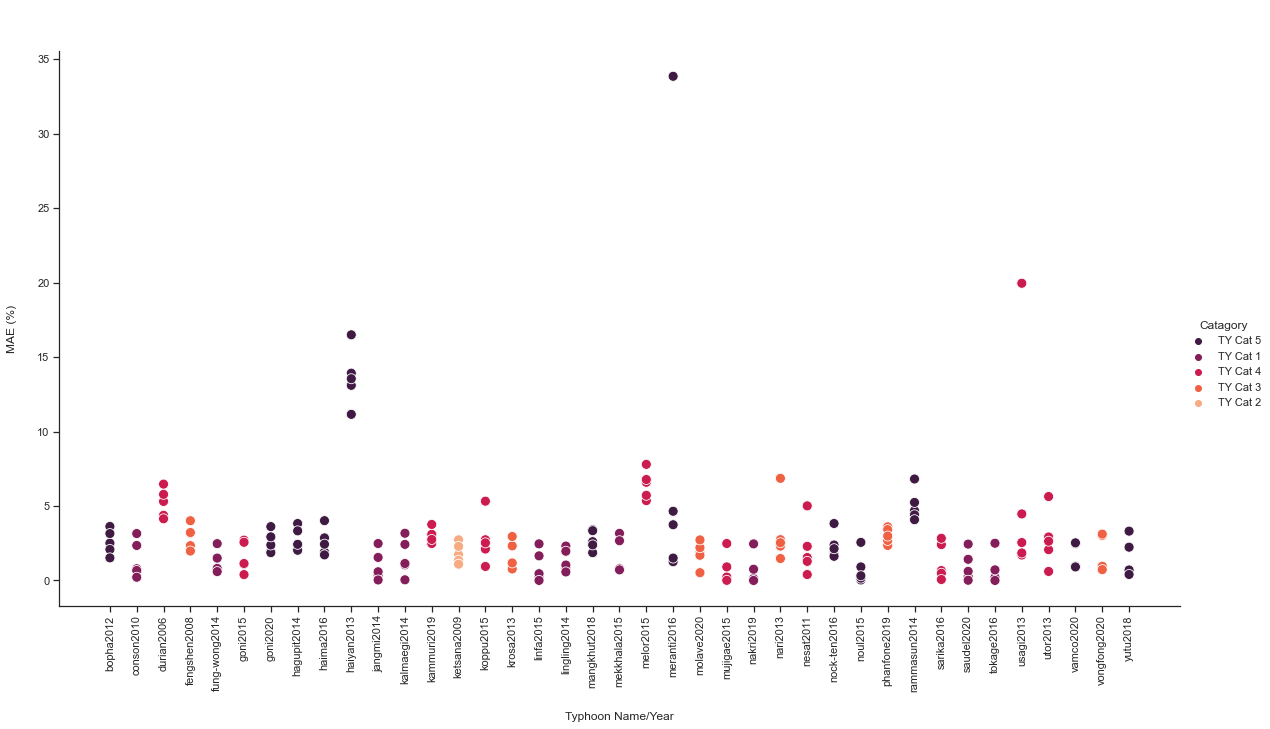

In [181]:
plt.rcParams.update({'font.size': 16}) 
 
g=sns.relplot(
    data=reset_df, x="typhoon", y="MAE", hue="cat",#style='Model',
    palette="rocket", marker="o", s=100
)
g.set_axis_labels("Typhoon Name/Year", "MAE (%)", labelpad=20)
g.legend.set_title("Catagory")
g.figure.set_size_inches(18.5, 9.5)
g.set_xticklabels(rotation=90)
g.ax.margins(.05)
g.despine(trim=False) 
g.add_legend(frameon=False)
g.legend.set_bbox_to_anchor((1.05, 1.01))
g.savefig('algorithms_comparsion_STY.jpg', format='jpg', dpi=400)

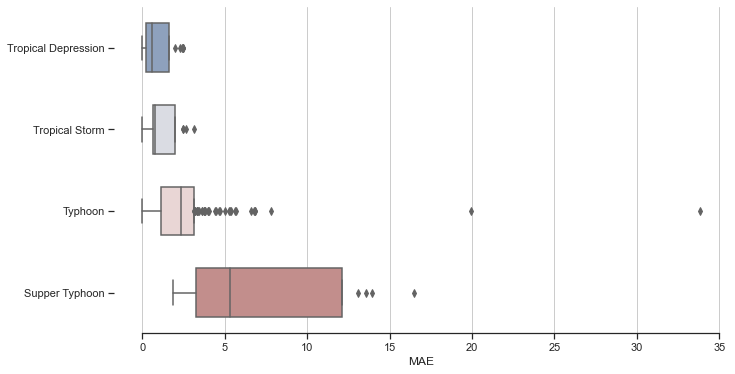

In [182]:
plt.rcParams.update({'font.size': 18})  
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(11, 6))
#ax.set_xscale("log")

 
# Plot the orbital period with horizontal boxes
#sns.boxplot(y='cat', x='MAE', data=reset_df, order=['TY Cat 5','TY Cat 4','TY Cat 3','TY Cat 2','TY Cat 1'],whis=[0, 75], width=.6, palette="vlag")

sns.boxplot(y='Catagory', x='MAE', data=reset_df, order=['Tropical Depression','Tropical Storm', 'Typhoon', 'Supper Typhoon'],
            whis=[0, 75], width=.6, palette="vlag")
# Add in points to show each observation,
#sns.stripplot(y='cat', x='MAE', data=reset_df,              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
sns.despine(trim=True, left=True)
f.savefig('clas_algorithms_comparsion_percatagory.jpg', format='jpg', dpi=600)

In [183]:
file_name = "models/output/v1/df_predicted_xgb_regr_.csv"
path = os.path.join(cdir, file_name)
df_predicted_xgb_regr=pd.read_csv(path)

file_name = "models/output/v1/df_predicted_rf_regr1.csv"
path = os.path.join(cdir, file_name)
df_predicted_rf_regr=pd.read_csv(path)

file_name = "models/output/v1/df_predicted_mean.csv"
path = os.path.join(cdir, file_name)
df_predicted_mean=pd.read_csv(path)
file_name = "models/output/v1/df_predicted_lr.csv"
path = os.path.join(cdir, file_name)
df_predicted_lr=pd.read_csv(path)



file_name = "models/output/v1/df_predicted_damagecurve.csv"
path = os.path.join(cdir, file_name)
df_predicted_damagecurve=pd.read_csv(path)
df_predicted_damagecurve=df_predicted_damagecurve[df_predicted_damagecurve['typhoon'].isin(list(df_predicted_lr.typhoon.values))]

In [188]:
models = {
    "Random Forest": df_predicted_rf_regr,
    "XGBoost": df_predicted_xgb_regr,
    "Average": df_predicted_mean,
    "Simple Linear Regression": df_predicted_lr,
    "UPCL damage curve": df_predicted_damagecurve,
}

mae = []
rmse = []
mape=[]
evs=[]

# add 'list' if error
for df_temp in models.values():
    df_temp["actual"].replace({0: 0.0001,}, inplace=True)
    df_temp["predicted"].replace({0: 0.0001,}, inplace=True)
    mae.append(mean_absolute_error( list(df_temp["actual"]), list(df_temp["predicted"])))
    rmse.append(mean_squared_error( list(df_temp["actual"]), list(df_temp["predicted"]), squared=False))
    mape.append(mean_absolute_percentage_error( list(df_temp["actual"]), list(df_temp["predicted"])))
    evs.append(explained_variance_score( list(df_temp["actual"]), list(df_temp["predicted"])))
        
df_results_reg = pd.DataFrame({"Models": list(models.keys()), "MAE": mae, "RMSE": rmse, "MAPE": mape,"EVS": evs})

display(df_results_reg)

,Models,MAE,RMSE,MAPE,EVS
0,Random Forest,2.478178,7.731202,1176.572753,0.297804
1,XGBoost,2.365638,7.957123,1463.087008,0.260261
2,Average,3.964107,9.288363,12603.832239,-0.013619
3,Simple Linear Regression,3.885801,8.386968,7753.448551,0.173649
4,UPCL damage curve,2.537305,9.475292,144.267840,-0.030834


In [189]:
### Results 

models = {
    "Random Forest": df_predicted_rf_regr,
    "XGBoost": df_predicted_xgb_regr,
    "Average": df_predicted_mean,
    "Simple Linear Regression": df_predicted_lr,
    "UPCL damage curve": df_predicted_damagecurve,
}

mae = {}
rmse = {}
mape={}
evs={}

# add 'list' if error
for keys,df_temp in models.items():
    mae1 = {}
    rmse1 = {}
    mape1={}
    evs1={}
 
    for key,groups in df_temp.groupby(['typhoon']):
        mae1[key]=mean_absolute_error(list(groups["actual"]),list( groups["predicted"]))
        rmse1[key]=mean_squared_error(list(groups["actual"]),list( groups["predicted"]), squared=False)
        mape1[key]=mean_absolute_percentage_error(list(groups["actual"]),list( groups["predicted"]))
        evs1[key]=explained_variance_score(list(groups["actual"]),list( groups["predicted"]))
    
 
        
    mae[keys]=mae1
    rmse[keys]=rmse1
    mape[keys]=mape1
    evs[keys]=evs1


#df_results_regr = pd.DataFrame({"Models": list(models.keys()), "MAE": mae, "RMSE": rmse})
#display(df_results_regr)


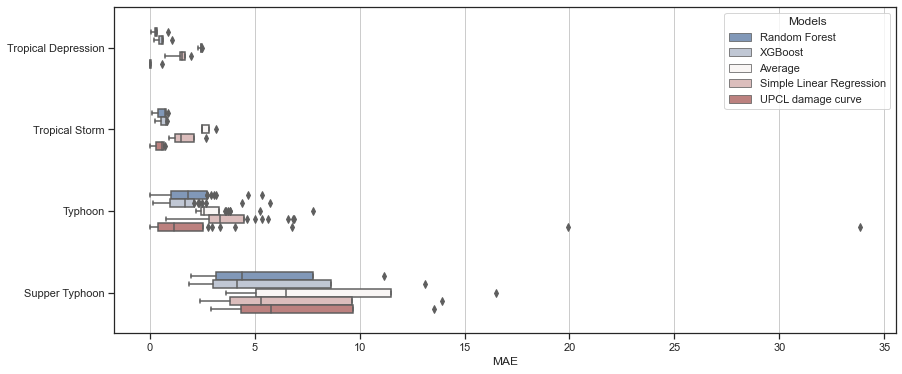

In [190]:
list_df=[]
for keys in mae.keys():
    df=pd.DataFrame.from_dict(mae[keys],orient='index')
    reset_df = df.reset_index()
    reset_df=reset_df.rename(columns={'index':'typhoon',0:'MAE'})
    reset_df['Models']=keys
    list_df.append(reset_df)

df_recall = pd.concat(list_df)

df_recall=df_recall.join(df_typhoon_typ.set_index('typhoon'), on='typhoon')
plt.rcParams.update({'font.size': 24})
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(14, 6 ))
#ax.set_xscale("log")

 
# Plot the orbital period with horizontal boxes
#sns.boxplot(y='Models', x='EVS', data=df_recall,whis=[0, 99], width=.4, palette="vlag")

#sns.boxplot(y='cat', x='MAE', data=df_recall, order=['TY Cat 5','TY Cat 4','TY Cat 3','TY Cat 2','TY Cat 1'],whis=[0, 75], width=.4, palette="vlag")
sns.boxplot(y='Catagory', x='MAE', data=df_recall,hue='Models', order=['Tropical Depression','Tropical Storm', 'Typhoon', 'Supper Typhoon'],
            whis=[0, 75], width=.5, palette="vlag")
# Add in points to show each observation
#sns.stripplot(y='Models', x='EVS', data=df_recall,      size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
#sns.despine(trim=True)#, left=True)
file_name = "models/output/figures/reg_catagory_comparsion_MAE.jpg"
path = os.path.join(cdir, file_name)

f.savefig(path, format='jpg', dpi=400)
#f.savefig('clas_algorithms_comparsion_MAE.jpg', format='jpg', dpi=600)

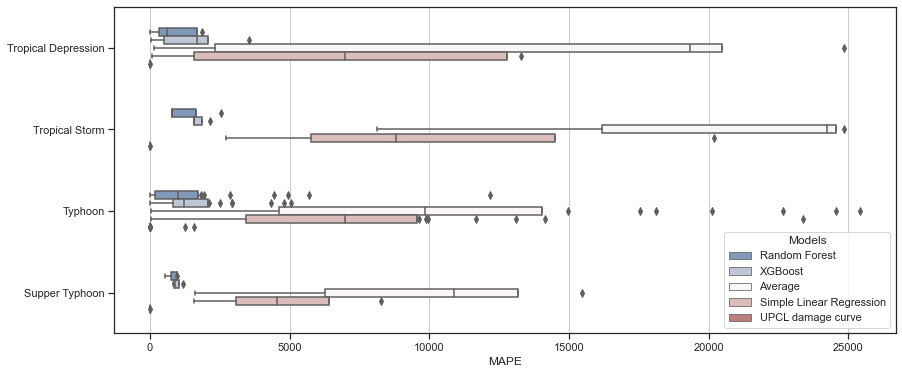

In [193]:
list_df=[]
for keys in mape.keys():
    df=pd.DataFrame.from_dict(mape[keys],orient='index')
    reset_df = df.reset_index()
    reset_df=reset_df.rename(columns={'index':'typhoon',0:'MAPE'})
    reset_df['Models']=keys
    list_df.append(reset_df)

df_recall = pd.concat(list_df)

df_recall=df_recall.join(df_typhoon_typ.set_index('typhoon'), on='typhoon')
plt.rcParams.update({'font.size': 24})
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(14, 6 ))
#ax.set_xscale("log")

 
# Plot the orbital period with horizontal boxes
#sns.boxplot(y='Models', x='EVS', data=df_recall,whis=[0, 99], width=.4, palette="vlag")

#sns.boxplot(y='cat', x='MAE', data=df_recall, order=['TY Cat 5','TY Cat 4','TY Cat 3','TY Cat 2','TY Cat 1'],whis=[0, 75], width=.4, palette="vlag")
sns.boxplot(y='Catagory', x='MAPE', data=df_recall,hue='Models', order=['Tropical Depression','Tropical Storm', 'Typhoon', 'Supper Typhoon'],
            whis=[0, 75], width=.5, palette="vlag")
# Add in points to show each observation
#sns.stripplot(y='Models', x='EVS', data=df_recall,      size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
#sns.despine(trim=True)#, left=True)
file_name = "models/output/figures/reg_catagory_comparsion_MAPE.jpg"
path = os.path.join(cdir, file_name)

f.savefig(path, format='jpg', dpi=400)
#f.savefig('clas_algorithms_comparsion_MAE.jpg', format='jpg', dpi=600)

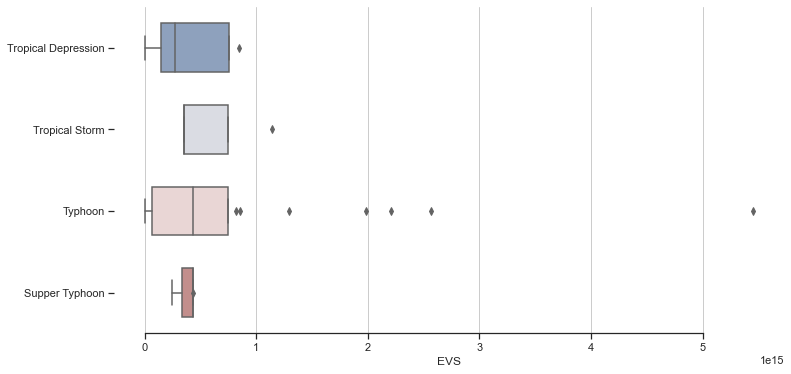

In [121]:
list_df=[]
for keys in evs.keys():
    df=pd.DataFrame.from_dict(mape[keys],orient='index')
    reset_df = df.reset_index()
    reset_df=reset_df.rename(columns={'index':'typhoon',0:'EVS'})
    reset_df['Models']=keys
    list_df.append(reset_df)

df_recall = pd.concat(list_df)

df_recall=df_recall.join(df_typhoon_typ.set_index('typhoon'), on='typhoon')
plt.rcParams.update({'font.size': 24})
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(12, 6 ))
#ax.set_xscale("log")

 
# Plot the orbital period with horizontal boxes
#sns.boxplot(y='Models', x='EVS', data=df_recall,whis=[0, 99], width=.4, palette="vlag")

#sns.boxplot(y='cat', x='EVS', data=df_recall, order=['TY Cat 5','TY Cat 4','TY Cat 3','TY Cat 2','TY Cat 1'], whis=[0, 75], width=.4, palette="vlag")
df_recall=df_recall.query('Models=="Random Forest"')
 
sns.boxplot(y='Catagory', x='EVS', data=df_recall, order=['Tropical Depression','Tropical Storm', 'Typhoon', 'Supper Typhoon'],
            whis=[0, 75], width=.6, palette="vlag")
# Add in points to show each observation
#sns.stripplot(y='Models', x='EVS', data=df_recall,      size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
sns.despine(trim=True, left=True)
file_name = "models/output/figures/reg_catagory_comparsion_evs.jpg"
path = os.path.join(cdir, file_name)

f.savefig(path, format='jpg', dpi=600)
#f.savefig('clas_algorithms_comparsion_recall.jpg', format='jpg', dpi=600)

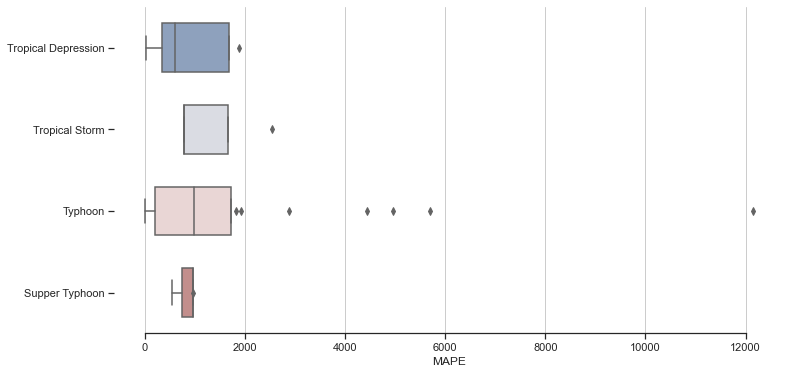

In [192]:
indicators={'mape':mape}
list_df=[]

for keys in mape.keys():
    df=pd.DataFrame.from_dict(mape[keys],orient='index')
    reset_df = df.reset_index()
    reset_df=reset_df.rename(columns={'index':'typhoon',0:'MAPE'})
    reset_df['Models']=keys
    list_df.append(reset_df)

df_recall = pd.concat(list_df)

df_recall=df_recall.join(df_typhoon_typ.set_index('typhoon'), on='typhoon')
plt.rcParams.update({'font.size': 24})
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(12, 6 ))
#ax.set_xscale("log")

 
# Plot the orbital period with horizontal boxes
#sns.boxplot(y='Models', x='EVS', data=df_recall,whis=[0, 99], width=.4, palette="vlag")

#sns.boxplot(y='cat', x='MAPE', data=df_recall, order=['TY Cat 5','TY Cat 4','TY Cat 3','TY Cat 2','TY Cat 1'],whis=[0, 75], width=.6, palette="vlag")
df_recall=df_recall.query('Models=="Random Forest"')
sns.boxplot(y='Catagory', x='MAPE', data=df_recall, order=['Tropical Depression','Tropical Storm', 'Typhoon', 'Supper Typhoon'],
            whis=[0, 75], width=.6, palette="vlag")
# Add in points to show each observation
#sns.stripplot(y='Models', x='EVS', data=df_recall,      size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
sns.despine(trim=True, left=True)
file_name = "models/output/figures/reg_catagory_comparsion_MAPE.jpg"
path = os.path.join(cdir, file_name)

f.savefig(path, format='jpg', dpi=600)
#f.savefig('clas_algorithms_comparsion_recall.jpg', format='jpg', dpi=600)

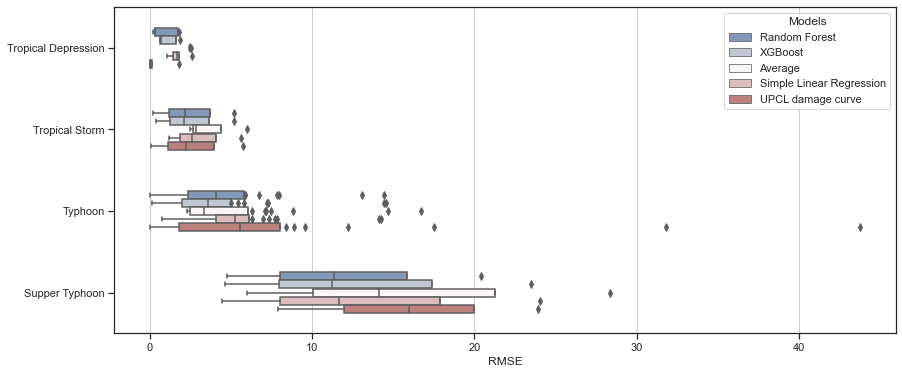

In [138]:
list_df=[]
for keys in rmse.keys():
    df=pd.DataFrame.from_dict(rmse[keys],orient='index')
    reset_df = df.reset_index()
    reset_df=reset_df.rename(columns={'index':'typhoon',0:'RMSE'})
    reset_df['Models']=keys
    list_df.append(reset_df)

df_recall = pd.concat(list_df)

df_recall=df_recall.join(df_typhoon_typ.set_index('typhoon'), on='typhoon')
plt.rcParams.update({'font.size': 24})
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(14, 6 ))
#ax.set_xscale("log")

 
# Plot the orbital period with horizontal boxes
#sns.boxplot(y='Models', x='EVS', data=df_recall,whis=[0, 99], width=.4, palette="vlag")

#sns.boxplot(y='cat', x='RMSE', data=df_recall, order=['TY Cat 5','TY Cat 4','TY Cat 3','TY Cat 2','TY Cat 1'], whis=[0, 75], width=.6, palette="vlag")
sns.boxplot(y='Catagory', x='RMSE', data=df_recall, hue='Models',order=['Tropical Depression','Tropical Storm', 'Typhoon', 'Supper Typhoon'],
            whis=[0, 75], width=.5, palette="vlag")
# Add in points to show each observation
#sns.stripplot(y='Models', x='EVS', data=df_recall,      size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
#sns.despine(trim=True)#, left=True)
file_name = "models/output/figures/reg_catagory_comparsion_rmse.jpg"
path = os.path.join(cdir, file_name)

f.savefig(path, format='jpg', dpi=400)